<a href="https://colab.research.google.com/github/hanaamulic/cookies/blob/main/Copy_of_gn_sklearn_pipeline_and_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving our decision tree

The goal of this notebook is to talk about decision trees and see how can we tune them to improve their performance.

This article on the [platform](https://platform.wbscodingschool.com/courses/data-science/14411/) will help you accomplish this task.

I made a change

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

housing = pd.read_csv('https://raw.githubusercontent.com/JoanClaverol/housing_data/main/housing-classification-iter3.csv')
housing.head()

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,MSZoning,Condition1,Heating,Street,CentralAir,Foundation
0,8450,65.0,856,3,0,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
1,9600,80.0,1262,3,1,0,2,298,0,0,RL,Feedr,GasA,Pave,Y,CBlock
2,11250,68.0,920,3,1,0,2,0,0,0,RL,Norm,GasA,Pave,Y,PConc
3,9550,60.0,756,3,1,0,3,0,0,0,RL,Norm,GasA,Pave,Y,BrkTil
4,14260,84.0,1145,4,1,0,3,192,0,0,RL,Norm,GasA,Pave,Y,PConc


## Create train and test



How can you split the data into train and test sets?

In [ ]:
# split the data
from sklearn.model_selection import train_test_split

housing.drop_duplicates(inplace=True)

X = housing.drop(columns=['Expensive'])
y = housing.filter(['Expensive'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.75, random_state=42)

## Preprocess the data

Is there any pre pre processing that needs to be applied to the numerical columns?

In [ ]:
housing.isna().sum()

LotArea           0
LotFrontage     257
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
Expensive         0
MSZoning          0
Condition1        0
Heating           0
Street            0
CentralAir        0
Foundation        0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

# define missing values imputer strategy
imp_lot = SimpleImputer(strategy='median')

In [ ]:
# apply the imputer
X.LotFrontage = imp_lot.fit_transform(X.LotFrontage.to_numpy().reshape(-1,1))
X_train.LotFrontage = imp_lot.fit_transform(X_train.LotFrontage.to_numpy().reshape(-1,1))
X_test.LotFrontage = imp_lot.fit_transform(X_test.LotFrontage.to_numpy().reshape(-1,1))

And to the categorical columns?

In [ ]:
housing.dtypes

LotArea           int64
LotFrontage     float64
TotalBsmtSF       int64
BedroomAbvGr      int64
Fireplaces        int64
PoolArea          int64
GarageCars        int64
WoodDeckSF        int64
ScreenPorch       int64
Expensive         int64
MSZoning         object
Condition1       object
Heating          object
Street           object
CentralAir       object
Foundation       object
dtype: object

In [ ]:
housing["CentralAir"].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
num_col = ["LotArea", "LotFrontage", "TotalBsmtSF", "BedroomAbvGr", "Fireplaces", "PoolArea", "GarageCars", "WoodDeckSF", "ScreenPorch"]
cat_col = ["Foundation", "CentralAir", "Street", "Heating", "Condition1", "MSZoning"]
cat_col

['Foundation', 'CentralAir', 'Street', 'Heating', 'Condition1', 'MSZoning']

In [ ]:
# OneHotEncoder on sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# encode variables with the once hot encoder
enc = OneHotEncoder(
    drop='first',
    sparse=False
)
X_train_enc = enc.fit_transform(X_train[cat_col])
X_test_enc = enc.transform(X_test[cat_col])

# apply the encoder to train
X_train_enc = pd.DataFrame(
    X_train_enc, 
    columns=enc.get_feature_names_out(), 
    index=X_train.index
)

X_train = pd.concat([X_train[num_col], X_train_enc], axis=1, ignore_index=False)

KeyError: ignored

In [ ]:
#X_train

In [ ]:
# apply the encoder to test
X_test_enc = pd.DataFrame(
    X_test_enc, 
    columns=enc.get_feature_names_out(), 
    index=X_test.index
)

X_test = pd.concat([X_test[num_col], X_test_enc], axis=1, ignore_index=False)

Is there any way to combine the pre processing done to categorical and numerical data?

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

categorical_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown = 'ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_col),
        ("cat", categorical_transformer, cat_col),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(random_state=42))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(preds, y_test)

0.8787878787878788

## Train your model

Can you train a model into the same pre process pipeline?

Can you automate the search of better parameters for a Decision tree? 

Take a look at this article on the [platform](https://platform.wbscodingschool.com/courses/data-science/14418/).

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__criterion': ["gini", "entropy"],
    'classifier__max_depth': range(1, 10),
    'classifier__min_samples_leaf': range(5, 20, 2),
    'classifier__min_samples_split': range(5, 40, 5),
}
 
search = GridSearchCV(clf, # you have defined this beforehand
                      param_grid, # your parameter grid
                      cv=5, # the value for K in K-fold Cross Validation
                      scoring='accuracy', # the performance metric to use, 
                      verbose=1) # we want informative outputs during the training process

search.estimator.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__fill_value', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__strategy', 'preprocessor__num__imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__quantile_range', 'preprocessor__num__scaler__unit_variance', 'preprocessor__num__scaler__with_centering', 'preprocessor__num__scaler__with_scaling', 'preprocessor__cat__categories', 'preprocessor__cat__drop', '

In [ ]:
search1 = search.fit(X_train, y_train)

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:174: UserWarning: Found unknown categories in colu

In [ ]:
print(search1.best_score_)
print("----------------")
print(search1.best_params_)
print("----------------")
search1.best_estimator_

0.9272608125819135
----------------
{'classifier__criterion': 'gini', 'classifier__max_depth': 4, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 25}
----------------


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['LotArea', 'LotFrontage',
                                                   'TotalBsmtSF',
                                                   'BedroomAbvGr', 'Fireplaces',
                                                   'PoolArea', 'GarageCars',
                                                   'WoodDeckSF',
                                                   'ScreenPorch']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler())]
)

categorical_transformer = OneHotEncoder(drop='first', sparse=False, handle_unknown = 'ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_col),
        ("cat", categorical_transformer, cat_col),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(max_depth = 4, min_samples_split = 25, min_samples_leaf = 5, random_state = 42))]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
accuracy_score(preds, y_test)

0.9173553719008265

How does your tree look like? (Plot it)

In [ ]:
col_names = num_col
col_names.extend(
    clf.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()
)

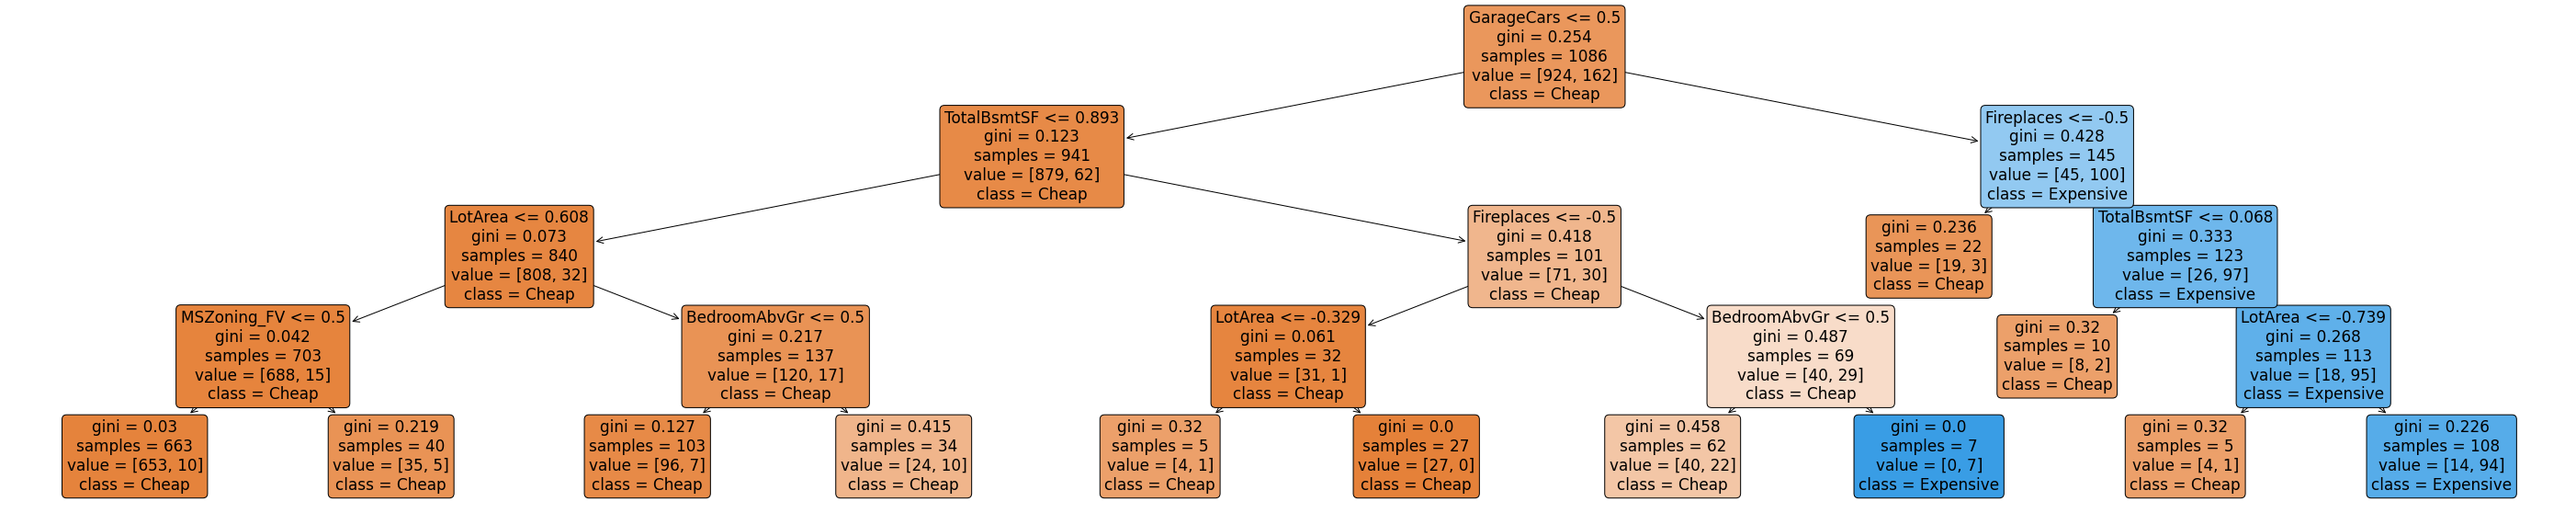

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,10))
plot_tree(
    clf['classifier'],
    filled=True,
    rounded=True,
    feature_names=col_names,
    class_names=['Cheap','Expensive']

);

## Apply your model

How can you compare the performance of your model between train and test? (Use the pipeline you created)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


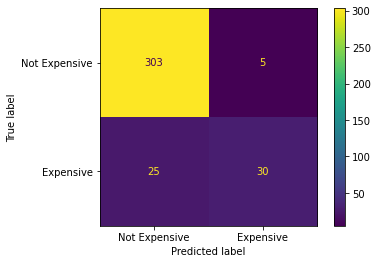

In [ ]:
plot_confusion_matrix(clf, X_test, y_test, display_labels=["Not Expensive", "Expensive"])